In [ ]:
import joblib
import numpy as np
import optuna
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import shap


/mnt/e/zhaohuiwang/dev/venvs/uv-venvs/pytorch/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def prepare_data(df):
    # Fill Nulls (Handling the Int64 and float64 mixed types)

    # Column "population" dtype is Int64 which is a Pandas "Nullable Integer." PyTorch tensors do not like Nullable types. Make sure to fill any missing values before converting to tensors:
    df['population'] = df['population'].fillna(df['population'].median()).astype('float64')

    df = df.fillna(df.median(numeric_only=True))


    cat_cols = ['sex_code', 'age_group', 'states_abbr']
    num_cols = [
        'year', 'population', 'real_gdp', 'real_personal_income', 
        'real_pce', 'gdp', 'personal_income', 'disposable_personal_income', 
        'pce', 'regional_price_parities', 'n_jobs', 
        'regional_price_deflator', 'non_smoker_rate'
    ]
    target_cols = ['breast', 'lung_and_bronchus', 'melanoma_of_the_skin']

    # 1. Use OrdinalEncoder for Input Features (X)
    # It results in a single column of integers (0 to n_categories - 1) per feature. Parameter handle_unknown='use_encoded_value' allows us to assign a specific number (like -1) to values the model never saw.
    cat_encoder = OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1
    )
    
    df[cat_cols] = cat_encoder.fit_transform(df[cat_cols].astype(str))

    # 2. Input Scaler (X)
    in_scaler = StandardScaler()
    df[num_cols] = in_scaler.fit_transform(df[num_cols])


    # 3. Target Scaler (y) - We use StandardScaler here because your targets 
    # are continuous rates, not categories. Otherwise LabelEncoder
    tar_scaler = StandardScaler()
    df[target_cols] = tar_scaler.fit_transform(df[target_cols])

    return df, cat_cols, num_cols, target_cols, cat_encoder, in_scaler, tar_scaler

In [4]:
class InputDataset(Dataset):
    def __init__(self, dataframe, cat_features, num_features, targets):
        self.cats = torch.tensor(dataframe[cat_features].values, dtype=torch.long)
        self.nums = torch.tensor(dataframe[num_features].values, dtype=torch.float32)
        self.y = torch.tensor(dataframe[targets].values, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.cats[idx], self.nums[idx], self.y[idx]

class MultiTargetModel(nn.Module):
    def __init__(self, emb_sizes, n_numeric, n_targets):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(c, s) for c, s in emb_sizes])
        n_emb = sum(s for c, s in emb_sizes)
        # self.network = nn.Sequential(
        #     nn.Linear(n_emb + n_numeric, 128),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),
        #     nn.Linear(128, 64),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),
        #     nn.Linear(64, n_targets)

        self.network = nn.Sequential(
            nn.Linear(n_emb + n_numeric, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.30),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.25),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(0.20),

            nn.Linear(32, n_targets)
        )

    def forward(self, x_cat, x_num):
        x = torch.cat([emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)] + [x_num], dim=1)
        return self.network(x)

In [5]:
data_path = Path.cwd().parent.parent /"data/model_df.parquet"
df = pd.read_parquet("data/model_df.parquet").drop(columns=["states", "fips", "sex"])

In [ ]:
# Prepare
df_proc, cat_cols, num_cols, target_cols, cat_encoder, in_scaler, tar_scaler = prepare_data(df)
emb_sizes = [(df_proc[col].nunique(), min(50, (df_proc[col].nunique() + 1) // 2)) for col in cat_cols]

# Heuristic Embedding Dimensions
# The older / simpler rule: min(50, (cardinality + 1) // 2)
# The newer / more aggressive rule: min(600, round(1.6 * cardinality ** 0.56))

# >>> cat_cols
# ['sex_code', 'age_group', 'states_abbr']
# >>> emb_sizes #(num_embeddings, embedding_dim)
# [(2, 1), (3, 2), (51, 26)]

In [7]:
# Split
train_df, val_df = train_test_split(df_proc, test_size=0.2, random_state=42)
train_loader = DataLoader(InputDataset(train_df, cat_cols, num_cols, target_cols), batch_size=64, shuffle=True)
val_loader = DataLoader(InputDataset(val_df, cat_cols, num_cols, target_cols), batch_size=64)

In [8]:
# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTargetModel(emb_sizes, len(num_cols), len(target_cols)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training with Early Stopping
best_loss = float('inf')
history = {'train': [], 'val': []}
patience, counter = 7, 0

for epoch in range(100):
    model.train()
    t_loss = 0
    for xc, xn, y in train_loader:
        xc, xn, y = xc.to(device), xn.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xc, xn), y)
        loss.backward(); optimizer.step()
        t_loss += loss.item()
    
    model.eval()
    v_loss = 0
    with torch.no_grad():
        for xc, xn, y in val_loader:
            v_loss += criterion(model(xc.to(device), xn.to(device)), y.to(device)).item()
    
    train_epoch_loss = t_loss/len(train_loader)
    val_epoch_loss = v_loss/len(val_loader)
    history['train'].append(train_epoch_loss)
    history['val'].append(val_epoch_loss)

    # # Early Stopping check
    # if val_epoch_loss < best_loss:
    #     best_loss = val_epoch_loss
    #     torch.save(model.state_dict(), 'best_model.pth')
    #     counter = 0
    # else:
    #     counter += 1
    #     if counter >= patience:
    #         print(f"Stopping at Epoch {epoch}")
    #         break

All artifacts saved. Use best_model.pth for inference.


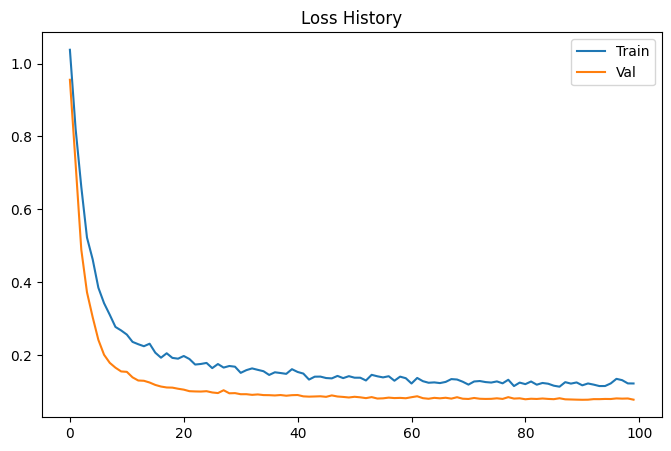

In [9]:
joblib.dump(in_scaler, 'input_scaler.pkl')
joblib.dump(tar_scaler, 'target_scaler.pkl')
joblib.dump(cat_encoder, 'label_encoders.pkl')

# Plot History
plt.figure(figsize=(8, 5))
plt.plot(history['train'], label='Train')
plt.plot(history['val'], label='Val')
plt.title('Loss History'); plt.legend(); plt.savefig('plots/loss.png')

print("All artifacts saved. Use best_model.pth for inference.")

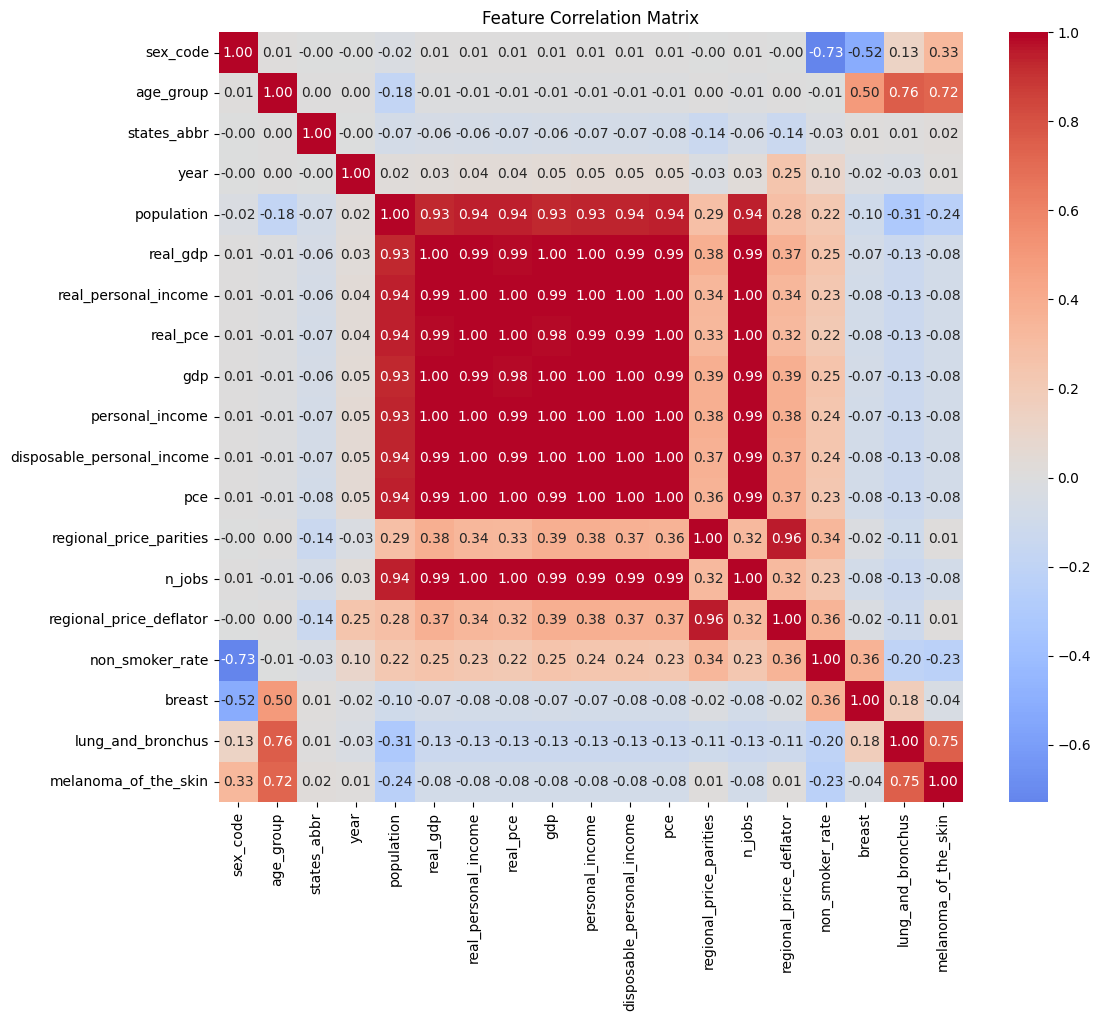

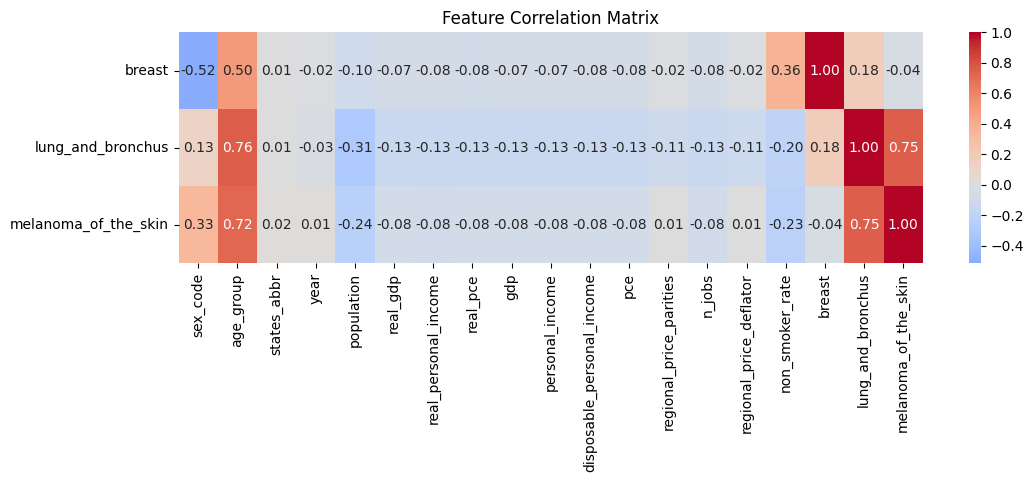

In [ ]:
# Correlation 
# 1. Combine numeric and categorical columns for the analysis
# We use df_proc which contains the encoded values
analysis_cols = cat_cols + num_cols + target_cols
corr_matrix = df_proc[analysis_cols].corr()

# 2.1 Plot the Heatmap - all features vs all features
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")    
save_path = f'plots/all_feature_correlation_plot.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 2.2 Plot the Heatmap - targets vs all features
corr_matrix = corr_matrix.loc[target_cols, ]

plt.figure(figsize=(12, 3))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")    
save_path = f'plots/target_feature_correlation_plot.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# SHAP value plot
batch_xc, batch_xn, _ = next(iter(val_loader))
background_xc = batch_xc[:100].to(device)
background_xn = batch_xn[:100].to(device)

# 1. PREPARE THE DATA FOR SHAP
# Number of samples to explain (Density)
num_samples = 150 

# Create unified background (reference) and test (explanation) sets
background_raw = np.concatenate([
    batch_xc[:100].cpu().numpy(), 
    batch_xn[:100].cpu().numpy()
], axis=1)

# Use kmeans to speed up KernelExplainer (summarizes data into 15 centroids)
background_summary = shap.kmeans(background_raw, 15)

# Extract a larger sample for a "dense" beeswarm plot
test_raw_dense = np.concatenate([
    df_proc.iloc[:num_samples][cat_cols].values, 
    df_proc.iloc[:num_samples][num_cols].values
], axis=1).astype(np.float32)

In [30]:
# 2. DEFINE THE UNIFIED MODEL WRAPPER
def model_predict_for_shap(combined_input):
    """Wrapper to split combined numpy array back into Categorical and Numeric tensors."""
    if len(combined_input.shape) == 1:
        combined_input = combined_input.reshape(1, -1)
        
    combined_tensor = torch.tensor(combined_input, dtype=torch.float32).to(device)
    
    # Slice: first 3 columns are categorical, remaining 13 are numeric
    x_cat = combined_tensor[:, :3].long()
    x_num = combined_tensor[:, 3:]
    
    model.eval()
    with torch.no_grad():
        preds = model(x_cat, x_num)
        # preds = champion_model(x_cat, x_num)
    return preds.cpu().numpy()

# 3. CALCULATE SHAP VALUES
print(f"Initializing Explainer and calculating SHAP for {num_samples} points...")
explainer = shap.KernelExplainer(model_predict_for_shap, background_summary)
# explainer = shap.DeepExplainer(model_predict_for_shap, background_summary) # dependends on tensorflow
# This will result in an array of shape (Samples, Features, Targets) -> (150, 16, 3)
shap_values_dense = explainer.shap_values(test_raw_dense)


Initializing Explainer and calculating SHAP for 150 points...


100%|██████████| 150/150 [00:04<00:00, 35.99it/s]


Generating high-density plot for: breast_cancer...


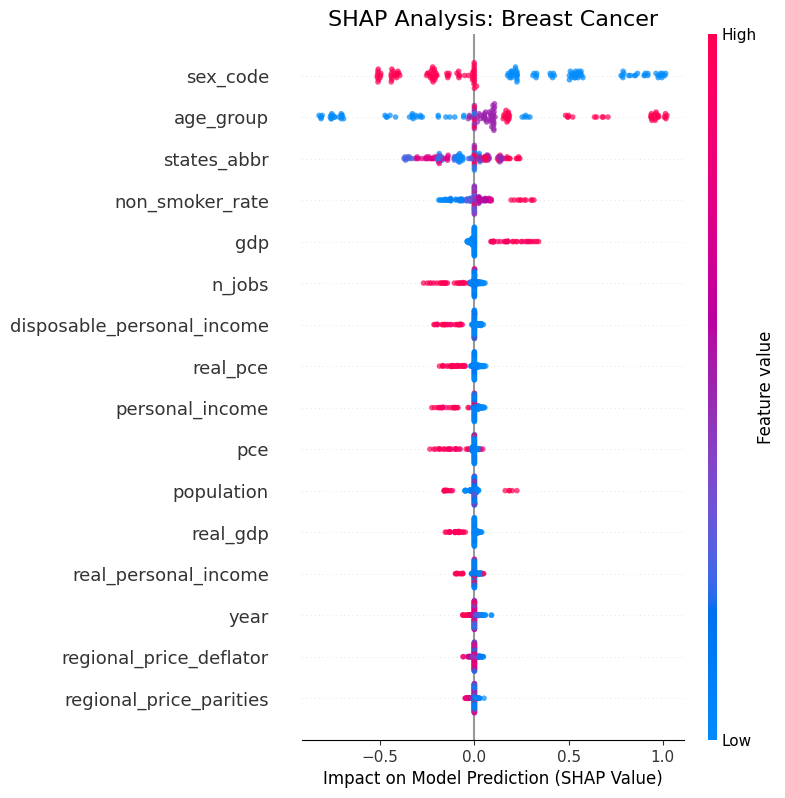

Generating high-density plot for: lung_and_bronchus...


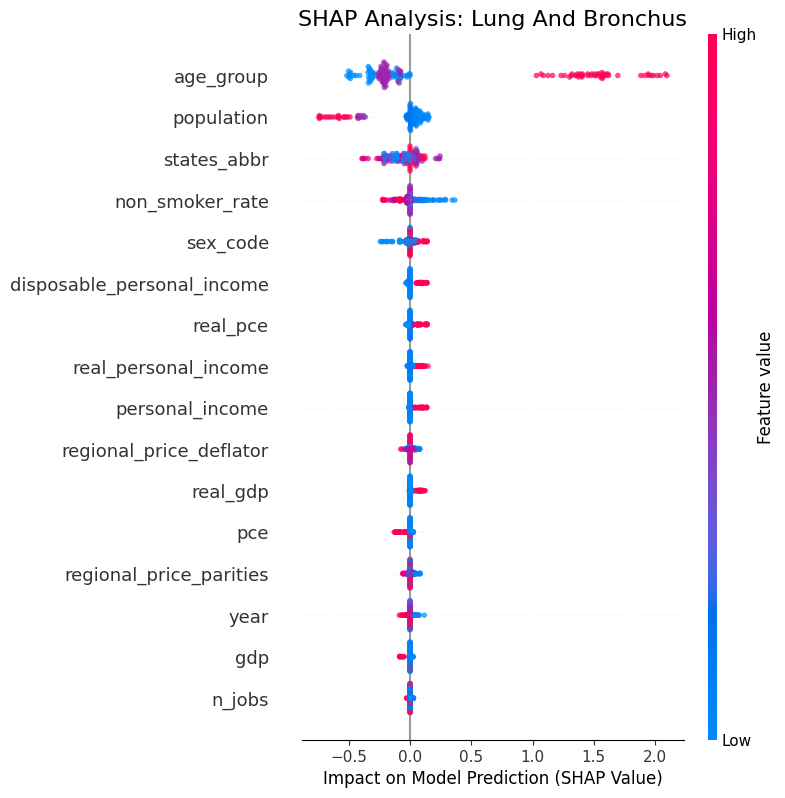

Generating high-density plot for: melanoma_of_the_skin...


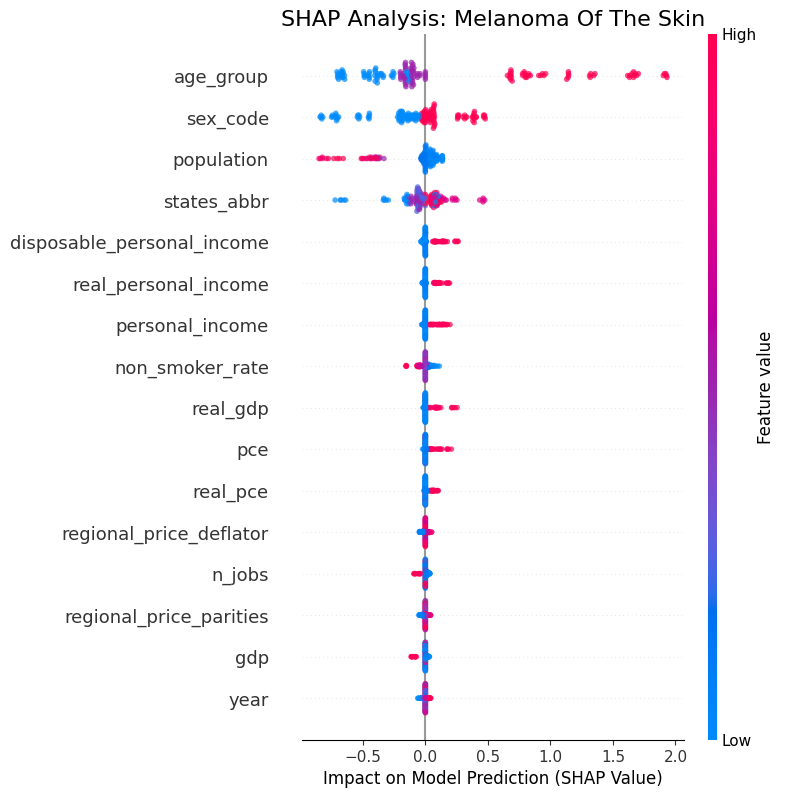

Execution Complete. High-density plots are in the 'plots' folder.


In [31]:
# 4. AUTOMATED PLOTTING AND SAVING
target_names = ['breast_cancer', 'lung_and_bronchus', 'melanoma_of_the_skin']
all_feature_names = cat_cols + num_cols
# os.makedirs('plots', exist_ok=True)
Path("plots").mkdir(parents=True, exist_ok=True)

for i, name in enumerate(target_names):
    print(f"Generating high-density plot for: {name}...")
    
    # Slice target from 3D array: (samples, features, target)
    # Check if shap_values is a list (typical for KernelExplainer) or array
    if isinstance(shap_values_dense, list):
        target_shap_matrix = shap_values_dense[i]
    else:
        target_shap_matrix = shap_values_dense[:, :, i]

    plt.figure(figsize=(14, 10))
    
    # Generate the Beeswarm dot plot
    shap.summary_plot(
        target_shap_matrix, 
        test_raw_dense, 
        feature_names=all_feature_names,
        plot_type="dot",
        show=False,
        alpha=0.7
    )
    
    plt.title(f"SHAP Analysis: {name.replace('_', ' ').title()}", fontsize=16)
    plt.xlabel("Impact on Model Prediction (SHAP Value)", fontsize=12)
    
    save_path = f'plots/{name}_shap_plot.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

print("Execution Complete. High-density plots are in the 'plots' folder.")


In [17]:
class DynamicCancerModel(nn.Module):
    def __init__(self, emb_sizes, n_numeric, n_targets, hidden_dims=[128, 64, 32], dropout=0.2):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(c, s) for c, s in emb_sizes])
        n_emb = sum(s for c, s in emb_sizes)
        
        layers = []
        in_dim = n_emb + n_numeric
        
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim)) 
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h_dim
        
        self.output_layer = nn.Linear(in_dim, n_targets)
        self.network = nn.Sequential(*layers)

    def forward(self, x_cat, x_num):
        # Concat embeddings and numeric data
        x = torch.cat([emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)] + [x_num], dim=1)
        x = self.network(x)
        return self.output_layer(x)

# 2. DEFINE THE OPTUNA OBJECTIVE
def objective(trial):
    # Suggest architecture parameters
    n_layers = trial.suggest_int('n_layers', 1, 4)
    hidden_dims = []
    for i in range(n_layers):
        # We suggest a size for each layer
        hidden_dims.append(trial.suggest_int(f'n_units_l{i}', 16, 256, log=True))
    
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.4)
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    # Initialize model using the class defined above
    # Assuming emb_sizes, num_cols, and device are already defined in your environment
    model = DynamicCancerModel(
        emb_sizes=emb_sizes, 
        n_numeric=len(num_cols), 
        n_targets=3, 
        hidden_dims=hidden_dims, 
        dropout=dropout_rate
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Mini training loop (5 epochs for speed)
    model.train()
    for epoch in range(5):
        for xc, xn, y in train_loader:
            xc, xn, y = xc.to(device), xn.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(xc, xn)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            
    # Evaluation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xc, xn, y in val_loader:
            xc, xn, y = xc.to(device), xn.to(device), y.to(device)
            val_loss += criterion(model(xc, xn), y).item()
    
    return val_loss / len(val_loader)

In [18]:
# 3. RUN THE STUDY
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print("\nBest Parameters Found:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


# Reconstructing the Champion Model
# 1. Extract dimensions from best_params
best_hidden_dims = [
    study.best_params[f'n_units_l{i}'] 
    for i in range(study.best_params['n_layers'])
]

# 2. Initialize the model with optimized values
champion_model = DynamicCancerModel(
    emb_sizes=emb_sizes,
    n_numeric=len(num_cols),
    n_targets=3,
    hidden_dims=best_hidden_dims,
    dropout=study.best_params['dropout']
).to(device)

# 3. Setup Optimizer with optimized Learning Rate
optimizer = torch.optim.Adam(champion_model.parameters(), lr=study.best_params['lr'])
criterion = nn.MSELoss()

# Training with Early Stopping

best_val_loss = float('inf')
patience = 10  # Stop if no improvement for 10 epochs
counter = 0

for epoch in range(100):
    champion_model.train()
    train_loss = 0
    for xc, xn, y in train_loader:
        xc, xn, y = xc.to(device), xn.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(champion_model(xc, xn), y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation Phase
    champion_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xc, xn, y in val_loader:
            xc, xn, y = xc.to(device), xn.to(device), y.to(device)
            val_loss += criterion(champion_model(xc, xn), y).item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    # Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(champion_model.state_dict(), 'best_champion_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

print(f"Final Validation Loss: {best_val_loss:.4f}")


[I 2026-01-12 17:59:13,920] A new study created in memory with name: no-name-a7789c1f-0dd2-46ba-971b-26afd2d065b2
[I 2026-01-12 17:59:14,091] Trial 0 finished with value: 0.753884756565094 and parameters: {'n_layers': 3, 'n_units_l0': 162, 'n_units_l1': 32, 'n_units_l2': 22, 'dropout': 0.18344247036473196, 'lr': 0.0007039442463181232}. Best is trial 0 with value: 0.753884756565094.
[I 2026-01-12 17:59:14,286] Trial 1 finished with value: 0.8477260708808899 and parameters: {'n_layers': 4, 'n_units_l0': 170, 'n_units_l1': 45, 'n_units_l2': 50, 'n_units_l3': 70, 'dropout': 0.39641046259798407, 'lr': 0.0011830970749565684}. Best is trial 0 with value: 0.753884756565094.
[I 2026-01-12 17:59:14,395] Trial 2 finished with value: 0.5611484169960022 and parameters: {'n_layers': 1, 'n_units_l0': 144, 'dropout': 0.18115907839272433, 'lr': 0.001090004327607792}. Best is trial 2 with value: 0.5611484169960022.
[I 2026-01-12 17:59:14,602] Trial 3 finished with value: 0.36220642924308777 and paramete


Best Parameters Found:
  n_layers: 2
  n_units_l0: 59
  n_units_l1: 114
  dropout: 0.10701761256312414
  lr: 0.009875978557840268
Early stopping triggered at epoch 24
Final Validation Loss: 0.0838


In [19]:
import joblib # Excellent for saving scalers
import json

# 1. Create a export directory
model_dir = Path("model_export")
model_dir.mkdir(parents=True, exist_ok=True)

# 2. Save the Model Weights
torch.save(champion_model.state_dict(), model_dir / 'champion_weights.pth')

# 3. Save the Scalers
joblib.dump(in_scaler, model_dir / 'input_scaler.pkl')
joblib.dump(tar_scaler, model_dir / 'target_scaler.pkl')
joblib.dump(cat_encoder, model_dir / 'label_encoders.pkl')

# 4. Save Metadata (Column names and Categories)
metadata = {
    'cat_cols': cat_cols,
    'num_cols': num_cols,
    'target_names': ['breast_cancer', 'lung_and_bronchus', 'melanoma_of_the_skin'],
    'best_params': study.best_params,
    'emb_sizes': emb_sizes
}

with open(model_dir / 'metadata.json', 'w') as f:
    json.dump(metadata, f)

print("Export Complete! Your 'model_export' folder is ready for deployment.")

Export Complete! Your 'model_export' folder is ready for deployment.


In [23]:
# How to Load and Predict Later
# 1. Re-initialize the architecture using the metadata
model = DynamicCancerModel(
    emb_sizes=metadata['emb_sizes'],
    n_numeric=len(metadata['num_cols']),
    n_targets=3,
    hidden_dims=best_hidden_dims # From metadata
)
model.load_state_dict(torch.load(model_dir / 'champion_weights.pth', weights_only=True))
model.eval()

# 2. Load the Scaler
in_scaler = joblib.load('input_scaler.pkl')
tar_scaler = joblib.load('target_scaler.pkl')
cat_encoder = joblib.load('label_encoders.pkl')

# 3. Preprocess New Data exactly like the old data
new_df = pd.read_parquet("data/model_df.parquet").drop(columns=["states", "fips", "sex"])

new_df[cat_cols] = cat_encoder.transform(new_df[cat_cols].astype(str))
new_df[num_cols] = in_scaler.transform(new_df[num_cols])

In [24]:

def generate_model_prediction(
    new_df: pd.DataFrame,
    model: torch.nn.Module,
    in_scaler: StandardScaler,
    tar_scaler: StandardScaler,
    cat_encoder: OrdinalEncoder,
    ci_iterations: int | None = None
) -> pd.DataFrame:
    """
    Takes a raw DataFrame and returns real-world predictions. When a ci_iterations is specified, it returns predictions with 95% confidence intervals using Monte Carlo Dropout.
    
    Args:
        new_df: The raw 2026 data (Pandas DataFrame)
        model: Your trained DynamicCancerModel
        in_scaler: The fitted StandardScaler for inputs
        tar_scaler: The fitted StandardScaler for targets
        label_encoders: The dictionary of fitted LabelEncoders
        ci_iterations: Whether to make prediction confidenc interval, if so how many iterations to run.
    """
    # Extract names dynamically
    num_cols = in_scaler.feature_names_in_.tolist()
    cat_cols = cat_encoder.feature_names_in_.tolist()
    target_names = tar_scaler.feature_names_in_.tolist()
    
    df_proc = new_df.copy()

    # 1. Encoding and Scaling
    df_proc[cat_cols] = cat_encoder.transform(df_proc[cat_cols].astype(str))
    df_proc[num_cols] = in_scaler.transform(df_proc[num_cols])
    
    device = next(model.parameters()).device
    x_cat = torch.tensor(df_proc[cat_cols].values, dtype=torch.long).to(device)
    x_num = torch.tensor(df_proc[num_cols].values, dtype=torch.float32).to(device)

    results = new_df.copy()

    # 4. INFERENCE
    results = new_df.copy()
    
    if not ci_iterations:
        model.eval()
        with torch.no_grad():
            scaled_preds = model(x_cat, x_num).cpu().numpy()
        real_preds = tar_scaler.inverse_transform(scaled_preds)
        
        for i, name in enumerate(target_names):
            results[f'{name}_pred'] = real_preds[:, i]
            
    else:
        # Monte Carlo Dropout for Confidence Intervals
        model.train() 
        all_samples = []

        # # SURGICAL MC DROPOUT: replace two lines above with the following
        # model.eval() # Start by freezing everything (Batch Norm, etc.)
        # for m in model.modules():
        #     if isinstance(m, torch.nn.Dropout):
        #         m.train() # Only turn Dropout back ON
        
        # all_samples = []
        # with torch.no_grad():

        
        for _ in range(ci_iterations):
            with torch.no_grad():
                scaled_sample = model(x_cat, x_num).cpu().numpy()
                all_samples.append(tar_scaler.inverse_transform(scaled_sample))
        
        all_samples = np.array(all_samples)
        
        mean_preds = np.mean(all_samples, axis=0)
        lower_bound = np.percentile(all_samples, 2.5, axis=0)
        upper_bound = np.percentile(all_samples, 97.5, axis=0)
        
        for i, name in enumerate(target_names):
            results[f'{name}_pred'] = mean_preds[:, i]
            results[f'{name}_lower_95'] = lower_bound[:, i]
            results[f'{name}_upper_95'] = upper_bound[:, i]
            
    return results

# Note: model.eval() vs model.eval() in the above sceneria
# model.eval() is used for Production / Deployment / Testing, the results is Deterministic (Always the same). All weights and batch norm are frozen and drop out layers is inactive.
# model.train() is used for Learning / Uncertainty Estimation. Here it is in torch.no_grad() context manager block, PyTorch does not track any math for the sake of gradient. Since there is no optimizer.step(), no mechanism to update weights. But it still active in dropout layers and updating batch norm, so the result is stochastic (change every time) and it is applied for confident intervals. 

# --- Example Usage ---
# Assuming 'new_df' is your new raw data loaded from a CSV
forecast_results = generate_model_prediction(df, champion_model, in_scaler, tar_scaler, cat_encoder, ci_iterations = None)
# forecast_results.to_csv("Cancer_Predictions_new.csv", index=False)


forecast_results[['breast_pred', 'breast']]
forecast_results[['lung_and_bronchus_pred', 'lung_and_bronchus']]
forecast_results[['melanoma_of_the_skin_pred', 'melanoma_of_the_skin']]


,melanoma_of_the_skin_pred,melanoma_of_the_skin
0,28.744852,12.000000
1,35.485397,25.000000
2,49.717270,38.000000
3,19.626881,10.000000
4,45.328045,34.000000
...,...,...
1505,42.101196,40.000000
1506,66.062149,68.000000
1507,57.950275,50.427572
1508,50.229195,41.000000
